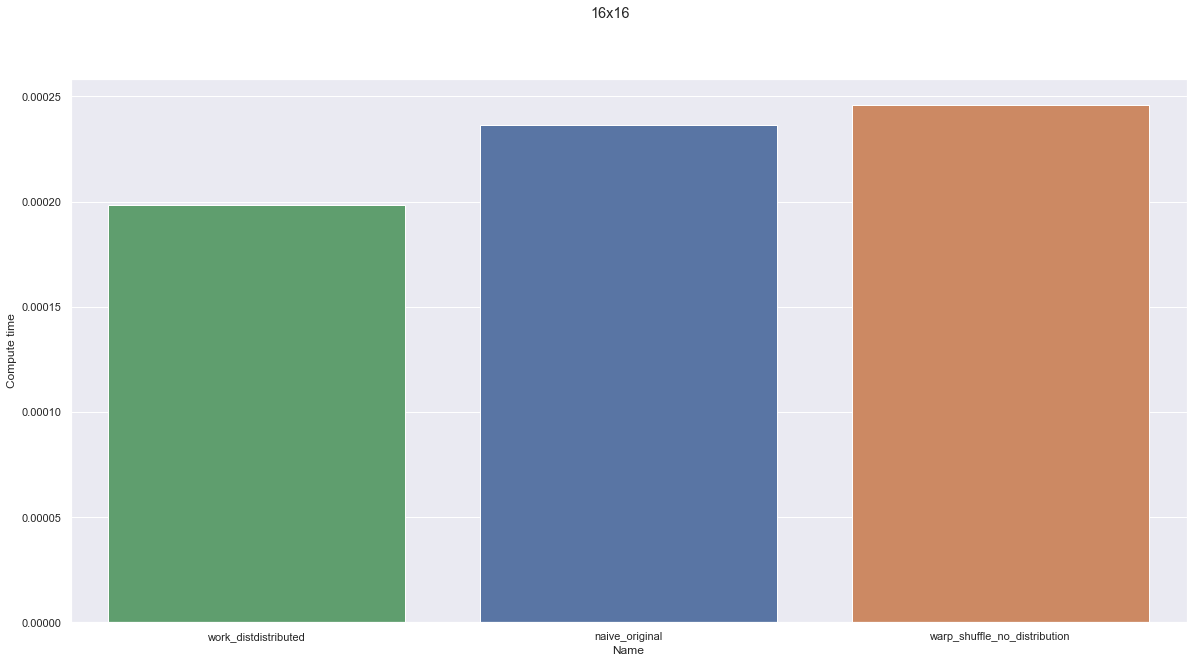

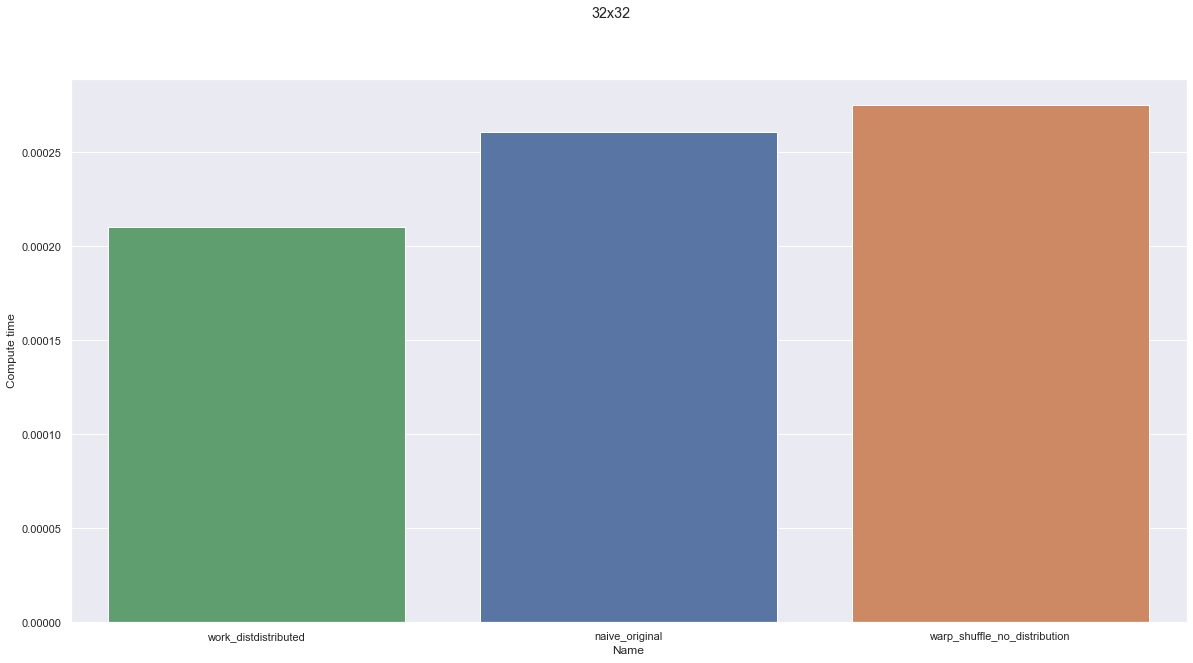

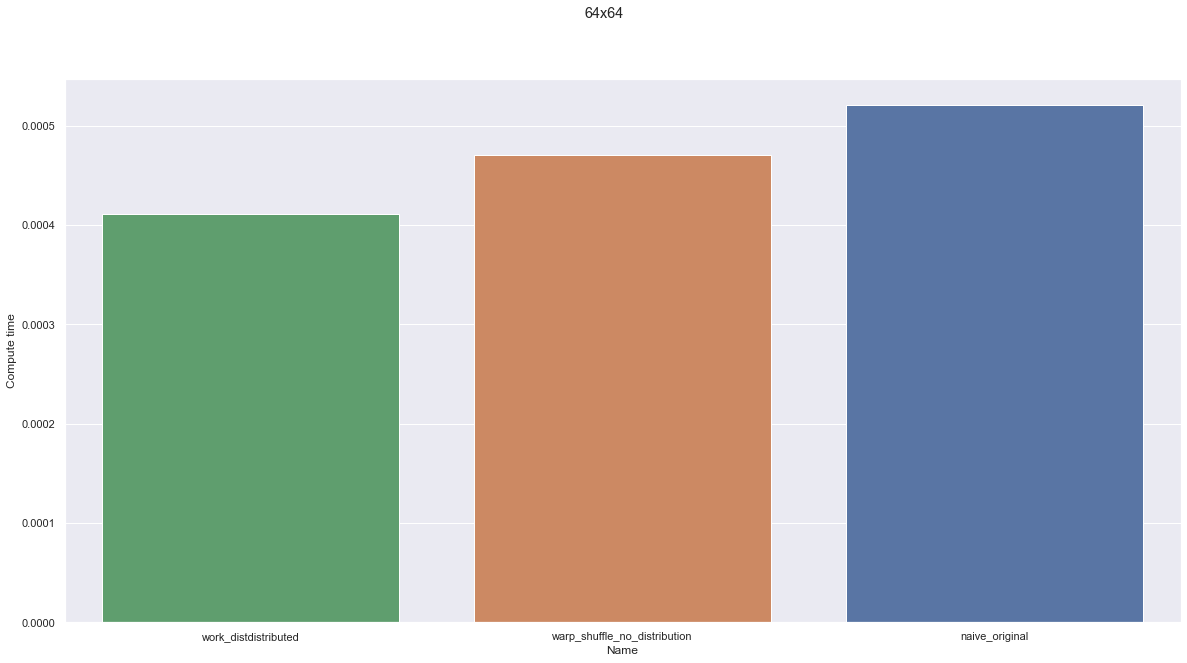

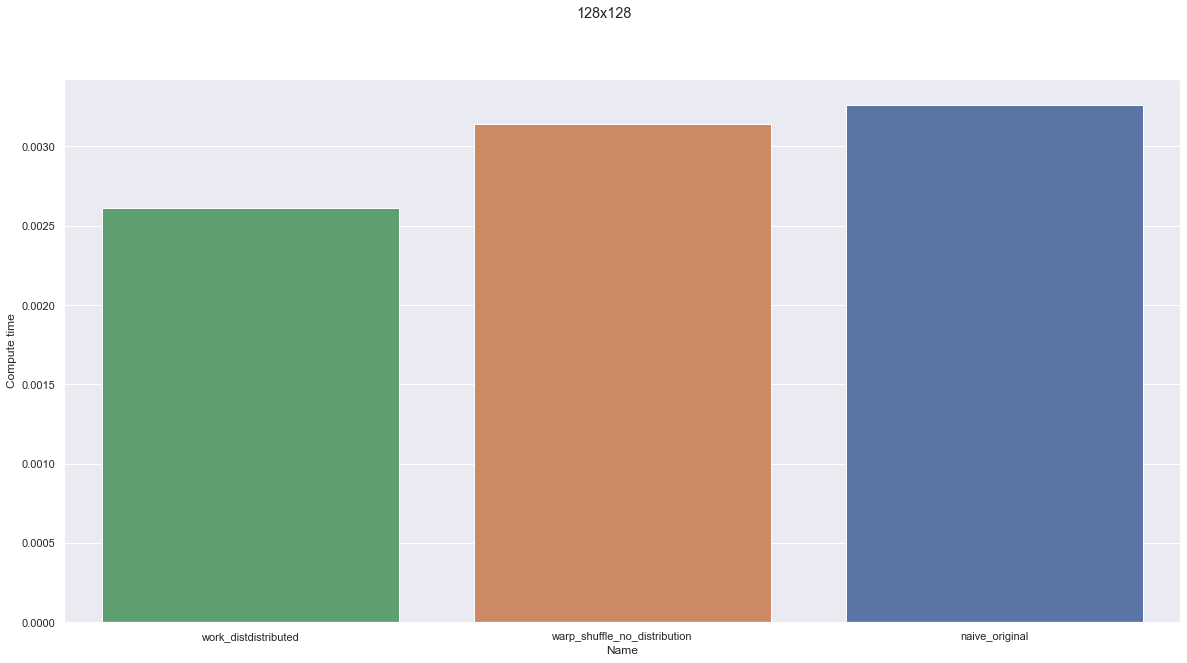

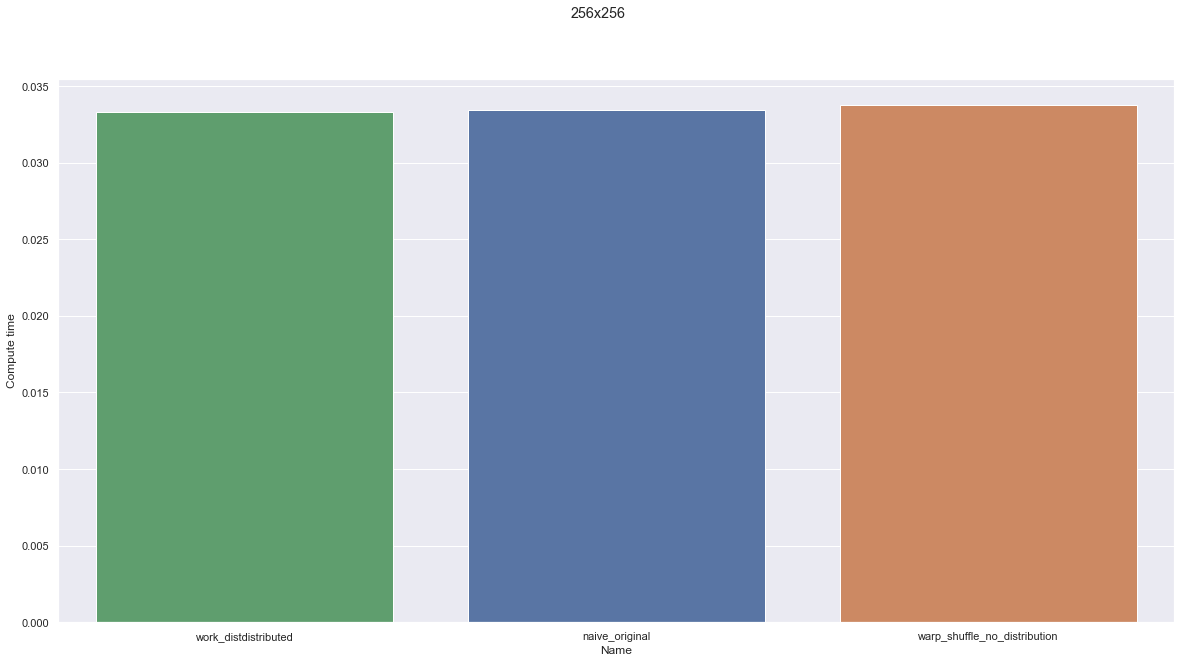

In [11]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

all_stages = ["Load", "Prepare", "Transfer", "Run", "Finalize"]
compute_stages = ["Prepare", "Transfer", "Run", "Finalize"]

sns.set(rc={'figure.figsize':(20,10)})

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "test" / "warp_shuffle")

group = benchmark.groups["one_to_one"]

for size in [16*16, 32*32, 64*64, 128*128, 256*256]:
    fig, ax = plt.subplots()
    fig.suptitle(f"{int(math.sqrt(size))}x{int(math.sqrt(size))}")

    data = pd.concat([run.data for run in group.runs if run.matrix_area() == size], join="inner")
    compute_times = data.groupby(["Name", "Args"])[compute_stages].apply(lambda x: x.mean().sum() / 1e9).reset_index(name="Compute time").sort_values("Compute time")
    compute_times = compute_times[compute_times["Compute time"] == compute_times.groupby(["Name"])["Compute time"].transform('min')]
    compute_times = compute_times[compute_times["Name"] != "fft"]

    names = sorted(compute_times["Name"].unique())
    palette = dict(zip(names, sns.color_palette(n_colors=len(names))))

    ax = sns.barplot(data=compute_times, x="Name", y="Compute time", ax=ax, dodge=False, palette=palette)
    #ax.tick_params(axis='x', labelrotation=90)


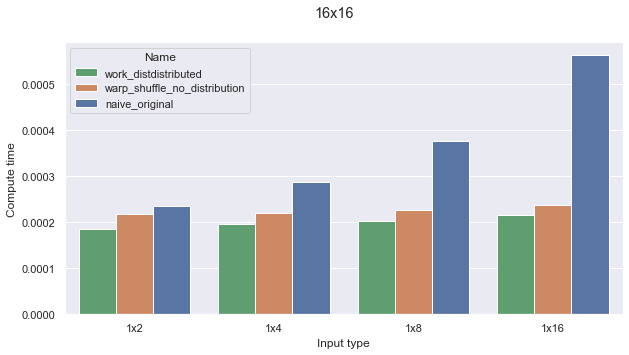

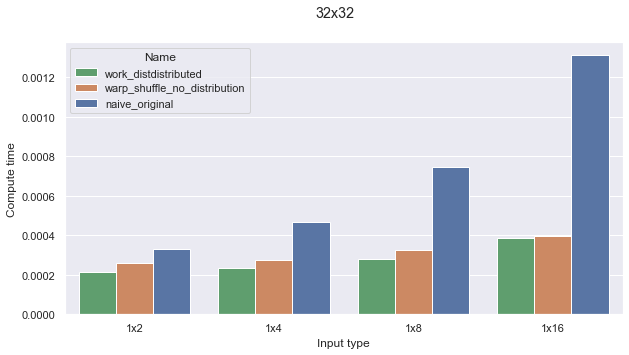

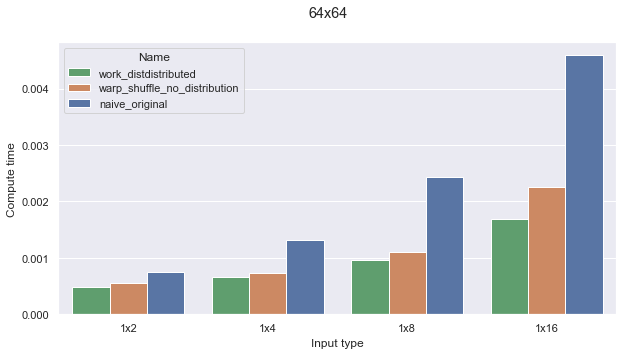

In [4]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group

from pathlib import Path
from typing import List, Tuple, Dict

all_stages = ["Load", "Prepare", "Transfer", "Run", "Finalize"]
compute_stages = ["Prepare", "Transfer", "Run", "Finalize"]

sns.set(rc={'figure.figsize':(10,5)})

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "test" / "warp_shuffle")

group = benchmark.groups["one_to_many"]

for size in [16*16, 32*32, 64*64]:
    fig, ax = plt.subplots()
    fig.suptitle(f"{int(math.sqrt(size))}x{int(math.sqrt(size))}")

    data = pd.concat([run.data for run in group.runs if run.matrix_area() == size], join="inner")
    compute_times = data.groupby(["Input type", "Name", "Args"])[compute_stages].apply(lambda x: x.mean().sum() / 1e9).reset_index(name="Compute time").sort_values("Compute time")
    compute_times = compute_times[compute_times["Compute time"] == compute_times.groupby(["Input type", "Name"])["Compute time"].transform('min')]

    compute_times = compute_times[compute_times["Name"] != "fft"]

    names = sorted(compute_times["Name"].unique())
    palette = dict(zip(names, sns.color_palette(n_colors=len(names))))

    ax = sns.barplot(data=compute_times, x="Input type", y="Compute time", hue="Name", ax=ax, dodge=True, palette=palette)

In [57]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

all_stages = ["Load", "Prepare", "Transfer", "Run", "Finalize"]
compute_stages = ["Prepare", "Transfer", "Run", "Finalize"]

sns.set(rc={'figure.figsize': (10, 60)})

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "test" / "warp_shuffle")

group = benchmark.groups["one_to_many"]

# names = sorted(compute_times["Name"].unique())
# palette = dict(zip(names, sns.color_palette(n_colors=len(names))))
input_sizes_str = set([str(run.input_size) for run in group.runs])

input_sizes = sorted([InputSize.from_string(input_size_str) for input_size_str in input_sizes_str], key=lambda in_size: (in_size.matrix_area(), in_size.right_matrices))

results = []
for idx, input_size in enumerate(input_sizes):
    work_dist_data = pd.concat([run.data for run in group.runs if run.name == "work_distdistributed" and run.input_size == input_size], join="inner")
    grouped = work_dist_data.groupby(["Args"])
    compute_times = grouped[compute_stages].mean().sum(axis=1) / 1e9
    compute_times.name = "Compute time"
    arguments = grouped[["Name", "block_y_size", "right_matrices_per_thread", "rows_per_thread", "distribution_type"]].first()
    result = pd.merge(compute_times, arguments, on="Args", sort=False)
    result = result.reset_index().sort_values("Compute time")

    naive = pd.concat([run.data for run in group.runs if run.name == "naive_original" and run.input_size == input_size], join="inner")

    naive_row = naive.head(1)[["Name", "Args"]]

    naive_row["Compute time"] = naive[compute_stages].mean().sum() / 1e9

    results.append((result, naive_row))

16_16_1_2: 21.19% faster
16_16_1_4: 32.04% faster
16_16_1_8: 46.22% faster
16_16_1_16: 61.50% faster
32_32_1_2: 35.47% faster
32_32_1_4: 49.50% faster
32_32_1_8: 62.69% faster
32_32_1_16: 70.73% faster
64_64_1_2: 36.31% faster
64_64_1_4: 50.43% faster
64_64_1_8: 60.59% faster
64_64_1_16: 63.13% faster


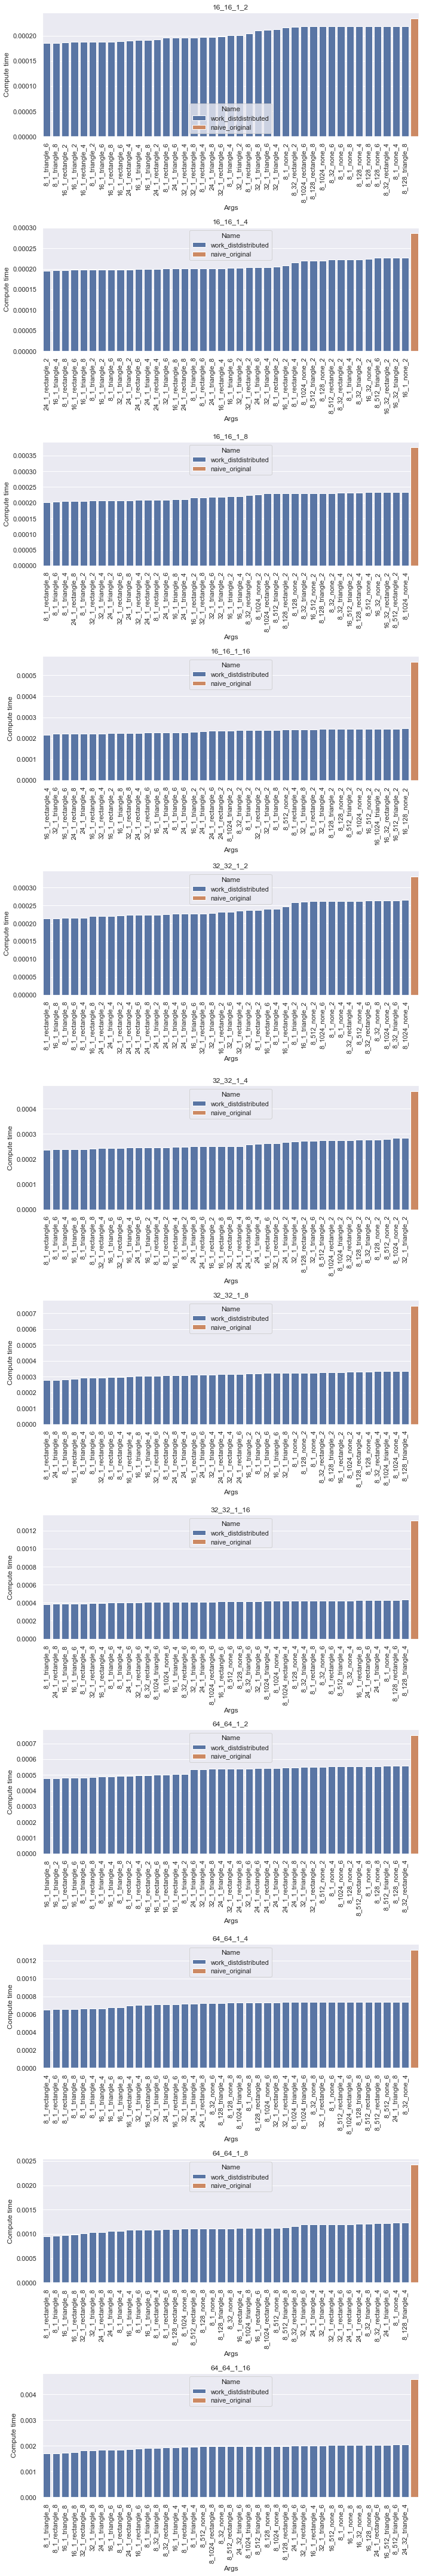

In [68]:
fig, axs = plt.subplots(nrows=len(input_sizes))
for idx, input_size in enumerate(input_sizes):

    work_dist, naive = results[idx]
    d = pd.concat([work_dist.head(40), naive], join="inner")
    ax = sns.barplot(data=d, x="Args", y="Compute time", hue="Name", ax=axs[idx], dodge=False)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(str(input_size))

    improvement = (1 - (work_dist.head(1)["Compute time"].iat[0] / naive.head(1)["Compute time"].iat[0]))*100
    print(f"{str(input_size)}: {improvement:.2f}% faster")

fig.tight_layout()